In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Major_plant_diseases",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5027 files belonging to 16 classes.


In [4]:
class_names = dataset.class_names
class_names

['Turmeric_Dry_Leaf',
 'Turmeric_Healthy_Leaf',
 'Turmeric_Leaf_Blotch',
 'Turmeric_Rhizome_Rot',
 'banana_cordana',
 'banana_healthy',
 'banana_pestalotiopsis',
 'banana_sigatoka',
 'cotton_Aphids',
 'cotton_Bacterial_blight',
 'cotton_Healthy',
 'cotton_Powdery_mildew',
 'sugarcane_BacterialBlights',
 'sugarcane_Healthy',
 'sugarcane_RedRot',
 'sugarcane_Rust']

In [5]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)

(32, 256, 256, 3)


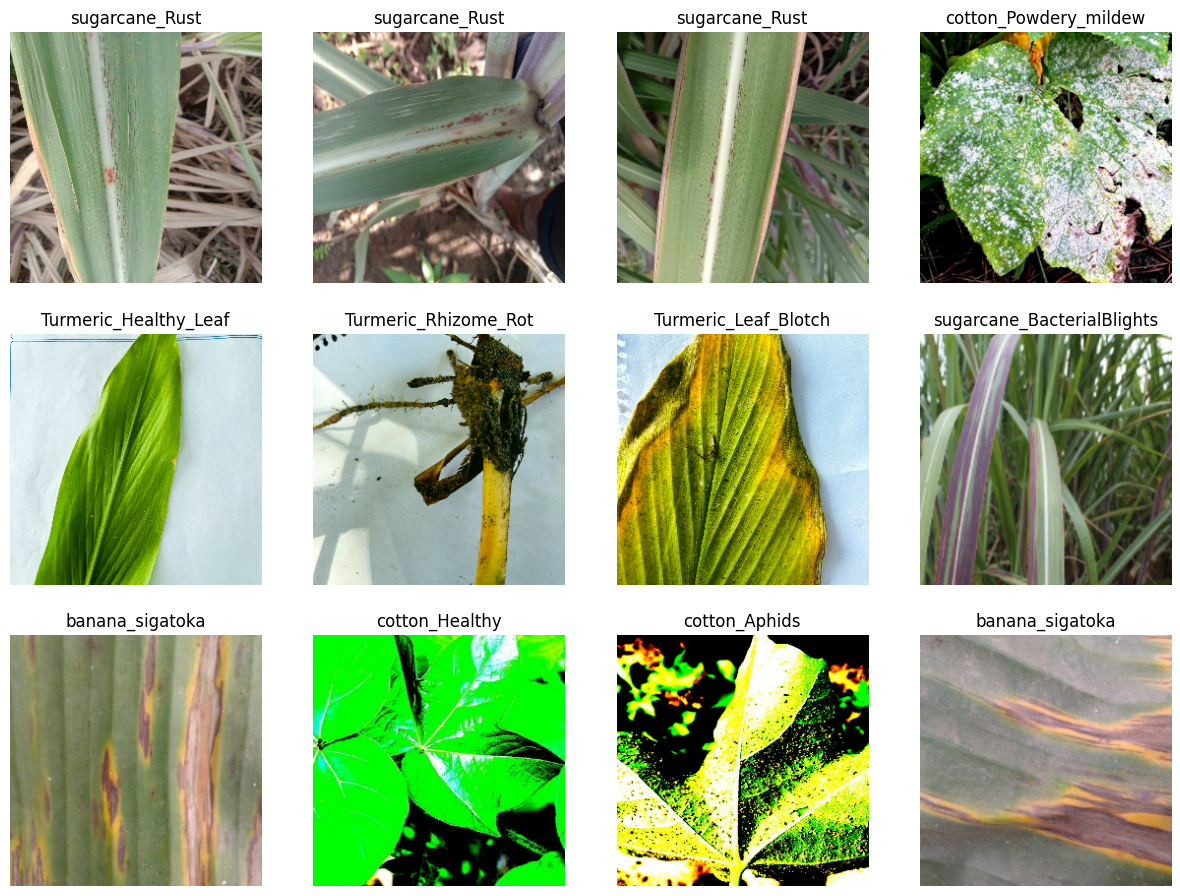

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_zoom_on_spots(image_path, zoom_scale=2, spot_area_threshold=500):
    img = cv2.imread(image_path)
    original_img = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    zoomed_spots = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > spot_area_threshold:
            x, y, w, h = cv2.boundingRect(cnt)
            spot = original_img[y:y+h, x:x+w]
            spot_zoomed = cv2.resize(spot, (w * zoom_scale, h * zoom_scale), interpolation=cv2.INTER_LINEAR)
            zoomed_spots.append(spot_zoomed)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(zoomed_spots)+1, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    for i, zoom_img in enumerate(zoomed_spots):
        plt.subplot(1, len(zoomed_spots)+1, i+2)
        plt.imshow(cv2.cvtColor(zoom_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Zoomed Spot {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


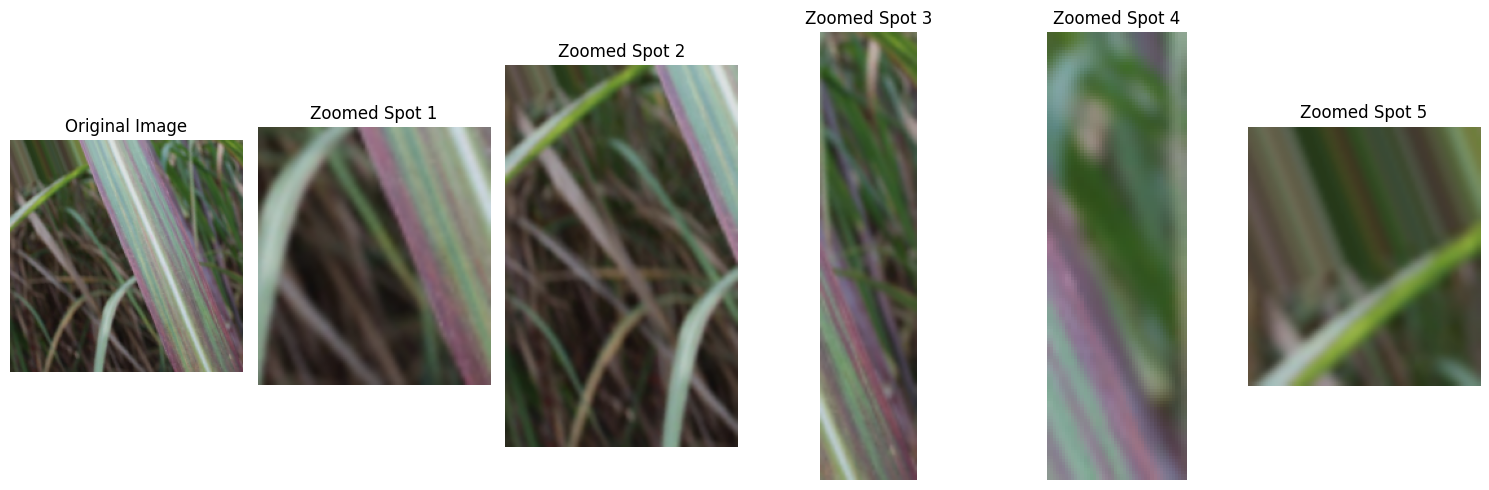

In [8]:
show_zoom_on_spots("/content/drive/MyDrive/Major_plant_diseases/sugarcane_BacterialBlights/cropped_Bacterial Blight_2651.png")


In [9]:
X = [[i] for i in range(5027)]
y = [i for i in range(5027)]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 4021 samples
Validation set: 503 samples
Test set: 503 samples


In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

126

In [15]:
len(val_ds)


15

In [16]:
len(test_ds)

17

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
n_classes = 16

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,592 (721.06 KB)

 Trainable params: 184,592 (721.06 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
     optimizer='adam',
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
     metrics=['accuracy']
)

In [20]:
history = model.fit(
     train_ds,
     epochs=EPOCHS,
     batch_size=BATCH_SIZE,
     verbose=1,
     validation_data = val_ds
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1389s 5s/step - accuracy: 0.1391 - loss: 2.5382 - val_accuracy: 0.3729 - val_loss: 1.8489
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 578s 4s/step - accuracy: 0.3788 - loss: 1.7389 - val_accuracy: 0.5000 - val_loss: 1.4266
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.5229 - loss: 1.2841 - val_accuracy: 0.6375 - val_loss: 1.0290
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.6149 - loss: 1.0787 - val_accuracy: 0.6104 - val_loss: 0.9718
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 563s 4s/step - accuracy: 0.6816 - loss: 0.8558 - val_accuracy: 0.7063 - val_loss: 0.8260
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.7040 - loss: 0.8334 - val_accuracy: 0.7563 - val_loss: 0.7024
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.7192 - loss: 0.7759 - val_accuracy: 0.7625 - val_loss: 0.6407
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 564s 4s/step - accuracy: 0.7541 - loss: 0.6677 - val_acc

In [21]:
scores = model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9032 - loss: 0.2658


In [22]:
scores

[0.2625459134578705, 0.90625]

In [23]:
history

In [24]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 126}

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
history.history['accuracy']

[0.18661004304885864,
 0.42493128776550293,
 0.5503372550010681,
 0.6277791857719421,
 0.6774919033050537,
 0.7007244825363159,
 0.7307019829750061,
 0.7639270424842834,
 0.7931551337242126,
 0.7824131846427917,
 0.7879090905189514,
 0.8206345438957214,
 0.8171371221542358,
 0.8393704891204834,
 0.8418685793876648,
 0.856357753276825,
 0.8586060404777527,
 0.8673495054244995,
 0.8698475956916809,
 0.8833374977111816]

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

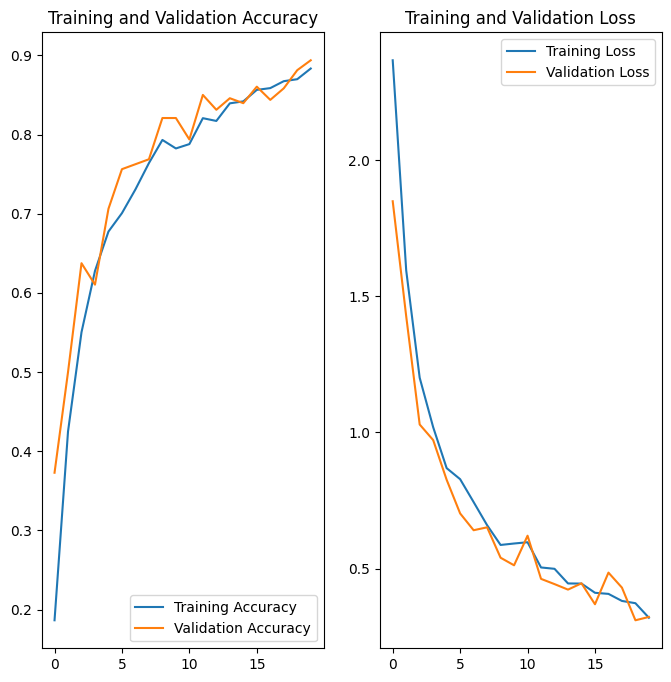

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Turmeric_Healthy_Leaf
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Turmeric_Healthy_Leaf


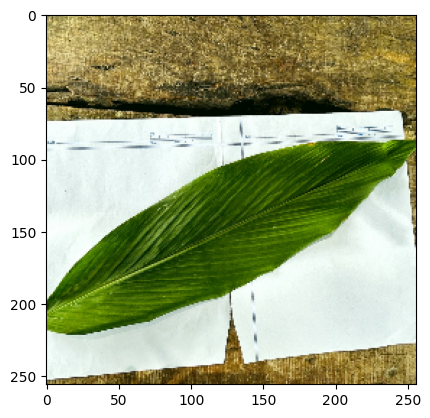

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])



In [30]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


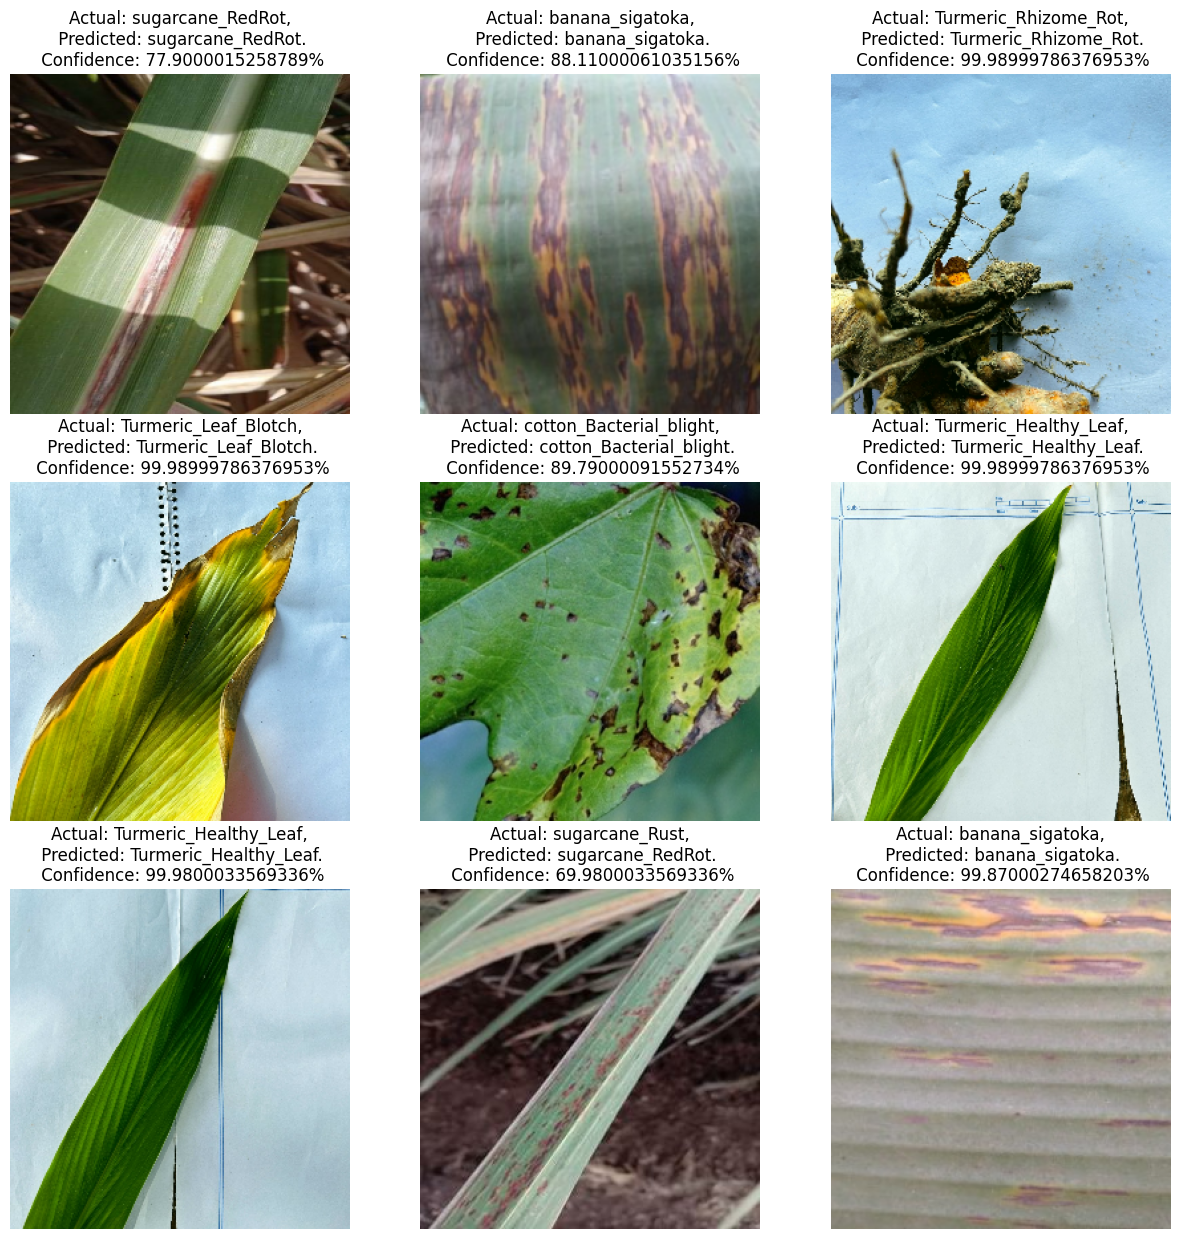

In [31]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


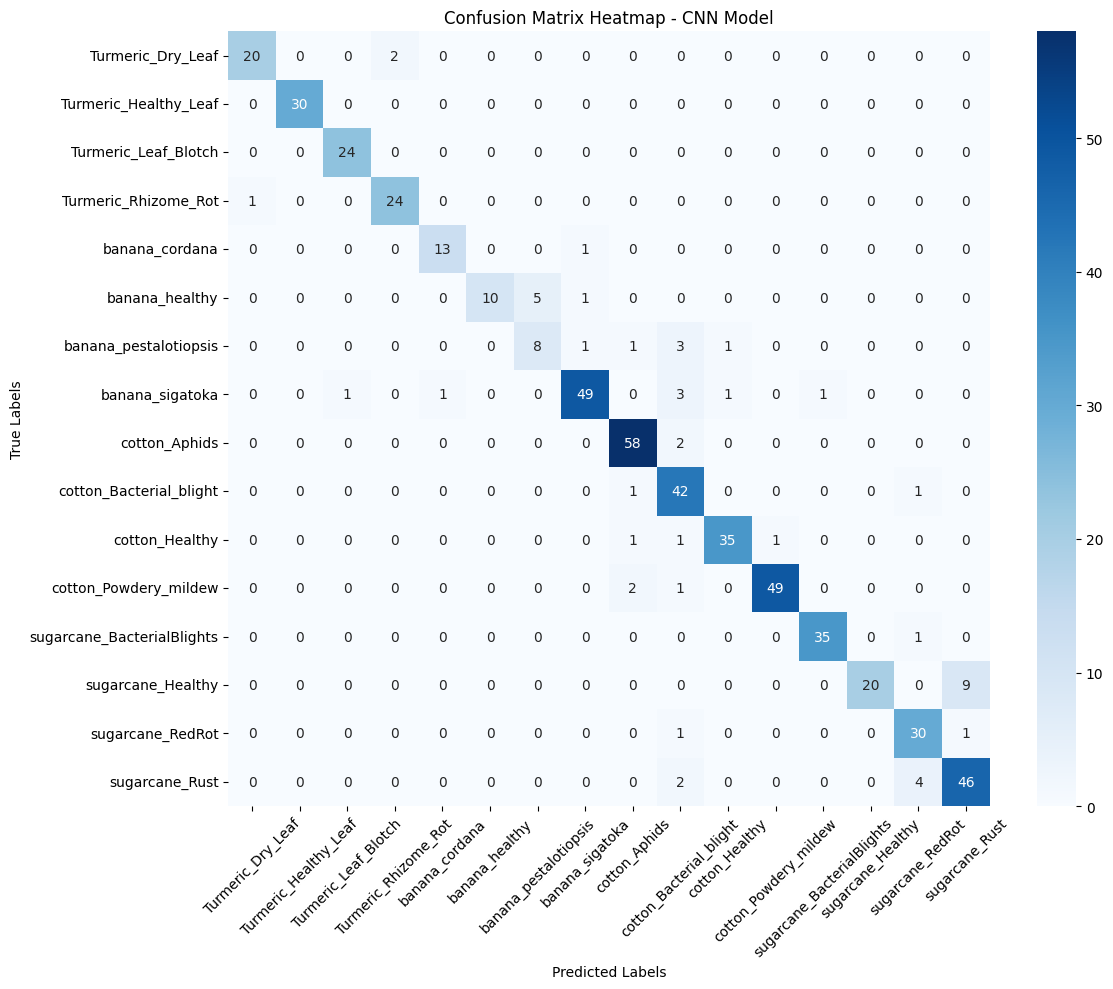

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix Heatmap - CNN Model")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

sensitivity = recall

cm = confusion_matrix(y_true, y_pred)
specificities = []

for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    specificities.append(specificity)

specificity_macro = np.mean(specificities)

print("CNN Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1-Score     : {f1:.4f}")
print(f"Sensitivity  : {sensitivity:.4f}")
print(f"Specificity  : {specificity_macro:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CNN Model Evaluation Metrics:
Accuracy     : 0.9062
Precision    : 0.9099
Recall       : 0.8836
F1-Score     : 0.8911
Sensitivity  : 0.8836
Specificity  : 0.9937


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

xception_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/Major_plant_diseases",
    shuffle=True,
    image_size=(299, 299),
    batch_size=32
)

class_names = xception_dataset.class_names
train_size = int(0.8 * len(xception_dataset))
val_size = int(0.1 * len(xception_dataset))
test_size = int(0.1 * len(xception_dataset))

train_ds = xception_dataset.take(train_size)
val_ds = xception_dataset.skip(train_size).take(val_size)
test_ds = xception_dataset.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

xception_model = Model(inputs=base_model.input, outputs=predictions)

xception_model.compile(optimizer=Adam(),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

history_xception = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

test_loss, test_acc = xception_model.evaluate(test_ds)
print(f"Xception Model Accuracy: {test_acc:.2f}")


Found 5027 files belonging to 16 classes.
Epoch 1/20
 30/126 ━━━━━━━━━━━━━━━━━━━━ 25:25 16s/step - accuracy: 0.0734 - loss: 40.9682